<a href="https://colab.research.google.com/github/jiahao303/music-classifier/blob/main/Music_Classifier_presentation_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Classifier
We are aiming to create a machine learning model finally to classify the genre of a song. The model will be able to classify the genre by reviewing the lyrics and the song's spotify ID. Now let's get started by looking at the machine learning pipeline!

## Techniques
Our model would take in both the lyrics and feature values of the song, which is called the **mixed data features**. Thus, we would like to do classification in a dataset containing both **text** and **numbers**.

### Key Tools
- Labeled data sets.
- The Keras functional API (alternative to Sequential API).
- Spotify Web API.

## Data Preparation



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

First, we read in the music dataset downloaded from Kaggle [Music Dataset: 1950 to 2019](https://www.kaggle.com/saurabhshahane/music-dataset-1950-to-2019) and get an inspection on one of the lyrics.

In [2]:
url = 'https://raw.githubusercontent.com/jiahao303/music-classifier/main/tcc_ceds_music.csv'

df = pd.read_csv(url)
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,0.000598,0.000598,0.048857,0.017104,0.263751,0.000598,0.039288,0.000598,0.000598,0.000598,0.000598,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,0.001284,0.001284,0.027007,0.001284,0.001284,0.001284,0.118034,0.001284,0.212681,0.051124,0.001284,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.158564,0.250668,0.002770,0.323794,0.002770,0.002770,0.002770,0.002770,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,0.001548,0.021500,0.001548,0.411536,0.001548,0.001548,0.001548,0.129250,0.001548,0.001548,0.081132,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,0.001350,0.001350,0.001350,0.463430,0.001350,0.001350,0.001350,0.001350,0.001350,0.029755,0.001350,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


In [3]:

df = df.drop("Unnamed: 0", axis =1)
df.at[5,"lyrics"]

'convoy light dead ahead merchantmen trump diesels hammer oily kill grind knuckle white eye alight slam hatch deadly night cunning chicken lair hound hell devil care run silent run deep final prayer warriors secret sleep merchantman nightmare silent death lie wait run silent run deep sink final sleep chill hearts fight open ocean wonder lethal silver fish boat shiver cast millions play killer victim fool obey order rehearse lifeboat shatter hull tear black smell burn jones eye watch crosswire tube ready medal chest weeks dead like rest run silent run deep final prayer warriors secret sleep merchantman nightmare'

We found that most of the neutral words such as pronouns (i.e. we, you, I) and auxiliaries are omitted since they have no use for the sentiment identifying.

Also, we want to focus on music that are recently released, so we filter out the songs released before 2000.

## Data Visualization

Now let's visualize the data and get a sense of how feature values plays a role in different songs.

We want to see how songs differ during different eras. In particular, we are going to divide songs into two subgroups: before 2000 and after 2000.

> #### Feature Vlues across different eras

In [4]:
df_pro = df[df["release_date"] <= 2000]
df_post = df[df["release_date"] > 2000]

In [5]:
df_pro = df_pro[['danceability','energy', 'loudness','acousticness', 'instrumentalness', 'valence']]
df_post = df_post[['danceability','energy', 'loudness','acousticness', 'instrumentalness', 'valence']]

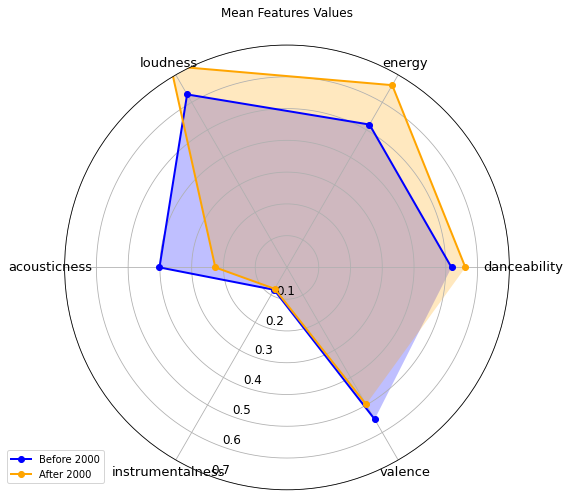

In [6]:
labels = list(df_pro)[:]
features_pro = df_pro.mean().tolist()
features_post = df_post.mean().tolist()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features_pro, 'o-', linewidth=2, label = "Before 2000", color= 'blue')
ax.fill(angles, features_pro, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7], ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7'  ], size=12)
plt.ylim(0,0.7)

ax.plot(angles, features_post, 'o-', linewidth=2, label = "After 2000", color= 'orange')
ax.fill(angles, features_post, alpha=0.25, facecolor='orange')
ax.set_title('Mean Features Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

We can observe that songs in recent years become incorporate more features of loudness, energy, and danceability and less of acousticness and valence, which reflects pulbic's changing tastes of songs.


> #### Energy over the course of the year
Let dive into a particular feature and see how it has changed over years.

In [7]:
px.scatter(x='release_date', y='energy', data_frame=df, 
           title="Energy over the course of the year", trendline="ols")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



From the plotly express scatter plot above, we can observe that the `energy` feature of songs generally follows a increasing pattern from the past to present.


> #### Popular genras across eras


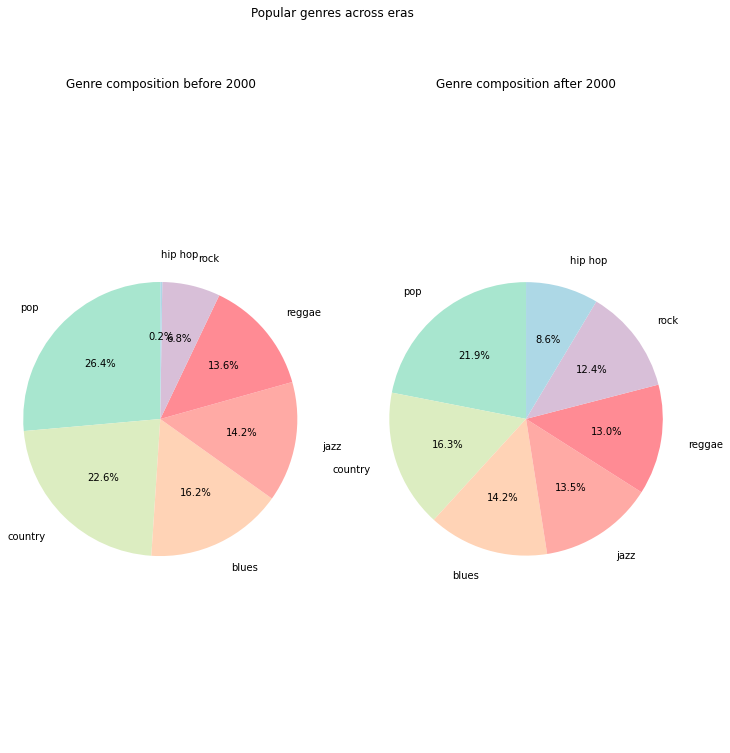

In [8]:
labels = list(df[df["release_date"] <= 2000]['genre'].unique())[:]
sizes = df[df["release_date"] <= 2000]['genre'].value_counts()[:]
colors = ['#a8e6cf', '#dcedc1', '#ffd3b6', '#ffaaa5', '#ff8b94', 'thistle', 'lightblue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
fig.suptitle("Popular genres across eras")
#fig = plt.figure(figsize = (10, 10))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', labeldistance = 1.2,
        shadow=False, startangle=90)
ax1.title.set_text('Genre composition before 2000')
ax1.axis('equal')
ax1.set_ylabel("")

labels2 = list(df[df["release_date"] > 2000]['genre'].unique())[:]
sizes2 = df[df["release_date"] > 2000]['genre'].value_counts()[:]
colors = ['#a8e6cf', '#dcedc1', '#ffd3b6', '#ffaaa5', '#ff8b94', 'thistle', 'lightblue']
ax2.pie(sizes2, labels=labels2, colors=colors, autopct='%1.1f%%', labeldistance = 1.2,
        shadow=False, startangle=90)
ax2.title.set_text('Genre composition after 2000')
ax2.axis('equal')
ax2.set_ylabel("")
plt.show()

Takeaways: `hip hop` becomes increasingly popular in recent years, its percentage increases from only 0.2% to 8.6%, while `country` songs have become less popular.

## Modeling: Classifying Genre with Lyrics and Feature Scalar Values
We want to use both the lyrics of the song and feature values such as `danceability`, `energy`, `loudness`, `acousticness`, `instrumentalness`, and `valence` to predict the genre of the song.

We filter out the songs released after 2000.

In [16]:
df = df[df["release_date"]>2000]

First, let's take a look at the values in `genre` .

In [17]:
df.groupby("genre").size()

genre
blues      1634
country    1308
hip hop     861
jazz       1356
pop        2199
reggae     1242
rock       1429
dtype: int64

Then, we implement the categorical encoding for the `genre` column. This step will help us to build the model in the future.

In [18]:
le2 = LabelEncoder()
le2.fit_transform(df["genre"])
num_genres = len(df["genre"].unique())
le_name_mapping = dict(zip(le2.classes_, le2.transform(le2.classes_)))
print(le_name_mapping)

{'blues': 0, 'country': 1, 'hip hop': 2, 'jazz': 3, 'pop': 4, 'reggae': 5, 'rock': 6}


In [38]:
df["genre"] = le2.fit_transform(df["genre"])

We omeve stopwords from the dataset, since they are common words and could stop the model from recognizing distinct lyrics in different genres.

In [39]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
df["lyrics"] = df["lyrics"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We also implement lemmatization, a technique that reduces every word to its root—for example, "am", "are", and "is" are reduced to "be", for the lyrics since the word "be" is the lemma of the other words. A lemma can be thought of as the base, least altered form of a word.



In [40]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df["lyrics"] = df.lyrics.apply(lemmatize_text)
df["lyrics"] = [' '.join(map(str, l)) for l in df["lyrics"]]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now we are ready to construct a `Tensorflow` Dataset. 
We define the scalars, which will be the predictive data for our model.

In [41]:
scalars = ['danceability',
           'energy',
           "loudness",
           'acousticness', 
           'instrumentalness', 
           'valence']        

Our model is going to use `lyrics` and `scalars` as the predictive data and `genre` as the target data.

Since we have multiple inputs, we are going to construct our `Dataset` from a tuple of dictionaries. The first dictionary is going to specify the different components in the predictor data, while the second dictionary is going to specify the components of the target data.

In [42]:
data = tf.data.Dataset.from_tensor_slices(
    (
        {
            "lyrics" : df[["lyrics"]], 
            "scalars" : df[scalars]
        }, 
        {
            "genre" : df[["genre"]]
        }
    )
)

In [43]:
df[["lyrics"]]

,lyrics
4843,yeah thinkin thought mind gonna finger gonna r...
4844,want learn reach grab cause everybody want bab...
4845,head head head head head head head head head h...
4846,mechakucha odotte sawago sawago headbanger yea...
4847,want come cause room drink half beer right thi...
...,...
28367,cause fuck leave scar tick tock clock come kno...
28368,mink thing chain ring braclets yap fame come f...
28369,get ban get ban stick crack relax plan attack ...
28370,check check yeah yeah hear thing call switch g...


We perform train/test/validation split. For each of the three split of `Datasets`, we are going to *batch* them into small chunks of data, which helps with training runtime later. 

In [44]:
print(len(data), data)

data = data.shuffle(buffer_size = len(data))

train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size).batch(20)
val   = data.skip(train_size).take(val_size).batch(20)
test  = data.skip(train_size + val_size).batch(20)

len(train), len(val), len(test)

10029 <TensorSliceDataset shapes: ({lyrics: (1,), scalars: (6,)}, {genre: (1,)}), types: ({lyrics: tf.string, scalars: tf.float64}, {genre: tf.int64})>


(351, 51, 101)

In the following text processing, we use Keras TextVectorization() method to convert the text into vectors and convert the inputs to Keras objects.

In [45]:
size_vocabulary = 2000

vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens= size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["lyrics"]))

In [46]:
scalars_input = keras.Input(
    shape = (len(scalars),), 
    name = "scalars",
    dtype = "float64"
)

In [47]:
lyrics_input = keras.Input(
    shape = (1,), 
    name = "lyrics",
    dtype = "string"
)

In [48]:
print(scalars_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float64, name='scalars'), name='scalars', description="created by layer 'scalars'")


In [49]:
print(lyrics_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='lyrics'), name='lyrics', description="created by layer 'lyrics'")


In [50]:
lyrics_features = vectorize_layer(lyrics_input)
lyrics_features = layers.Embedding(size_vocabulary, 7, name = "embedding")(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.GlobalAveragePooling1D()(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.Dense(64, activation='relu')(lyrics_features)

In [51]:
scalar_features = layers.Dense(64, activation='relu')(scalars_input)

In the following part, we are going to concatenate the output derived from lyrics pipeline and scalars pipeline. 

In [52]:
main = layers.concatenate([lyrics_features, scalar_features], axis = 1)
main = layers.Dense(256, activation='relu')(main)
main = layers.Dense(64, activation='relu')(main)
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(num_genres, name = "genre", activation = 'softmax')(main)

In [53]:
model = keras.Model(
    inputs = [lyrics_input, scalars_input],
    outputs = output
)

So far, we have successfully built the model. Use the `plot_model()` function to take a look at the visualized structure of the model.

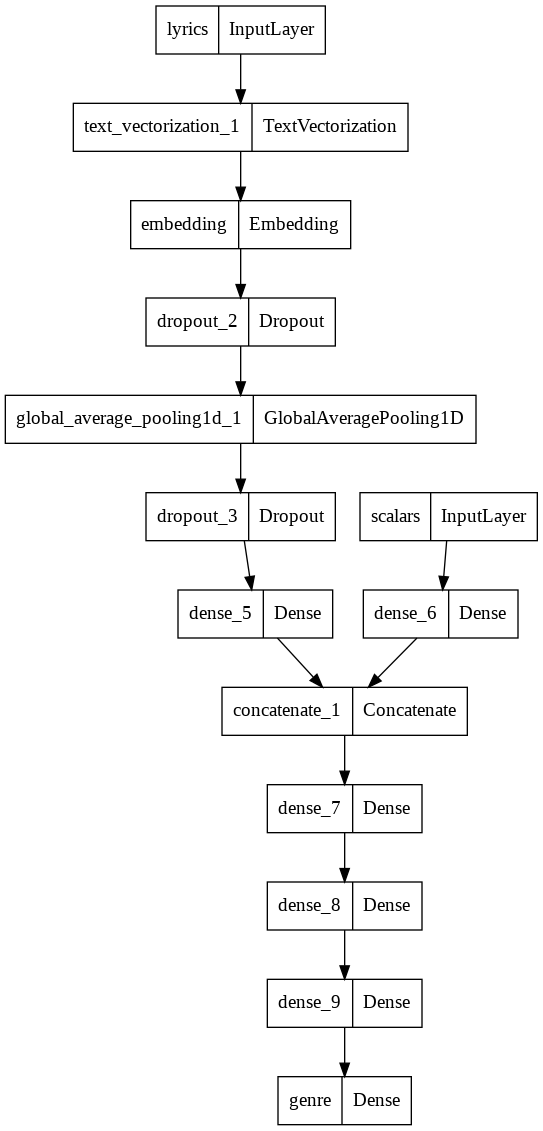

In [54]:
keras.utils.plot_model(model)

Then, we train and evaluate the model.

In [55]:
model.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [56]:
history = model.fit(train, 
                    validation_data=val,
                    epochs = 120, 
                    verbose = True)

Epoch 1/120
351/351 [==============================] - 5s 9ms/step - loss: 1.7282 - accuracy: 0.3050 - val_loss: 1.6288 - val_accuracy: 0.3353
Epoch 2/120
351/351 [==============================] - 3s 8ms/step - loss: 1.5969 - accuracy: 0.3540 - val_loss: 1.5546 - val_accuracy: 0.3922
Epoch 3/120
351/351 [==============================] - 3s 8ms/step - loss: 1.5313 - accuracy: 0.3969 - val_loss: 1.4585 - val_accuracy: 0.4242
Epoch 4/120
351/351 [==============================] - 3s 9ms/step - loss: 1.4808 - accuracy: 0.4219 - val_loss: 1.4362 - val_accuracy: 0.4681
Epoch 5/120
351/351 [==============================] - 3s 9ms/step - loss: 1.4180 - accuracy: 0.4546 - val_loss: 1.3594 - val_accuracy: 0.4910
Epoch 6/120
351/351 [==============================] - 3s 9ms/step - loss: 1.3879 - accuracy: 0.4736 - val_loss: 1.3704 - val_accuracy: 0.4770
Epoch 7/120
351/351 [==============================] - 3s 9ms/step - loss: 1.3422 - accuracy: 0.4954 - val_loss: 1.3191 - val_accuracy: 0.5080

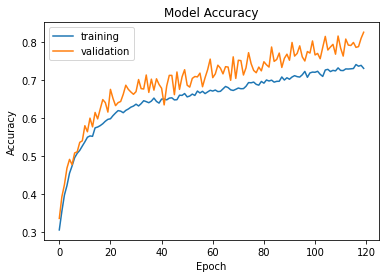

In [57]:
from matplotlib import pyplot as plt

# summarize history for accuracy
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["training","validation"], loc = "upper left")


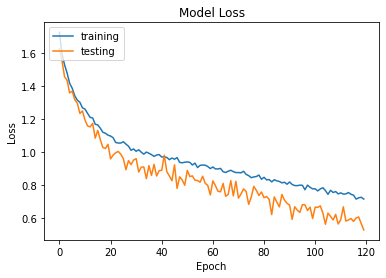

In [58]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()

Observing the training history, we can see that the validation accuracy stablizes around **80%** and the loss gradually decreases.

## Saving the model
Finally, we save the trained model from Google Colab to the Google Drive using the following code. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
model.save('/content/gdrive/MyDrive/fake_model4', save_format='tf')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
